In [74]:
!pip install statsmodels

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [76]:
data=pd.read_csv("train.csv")
print(data.head())
print(data.isna().sum())
data=data.dropna()
print(data.isna().sum())

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
date     0
store    0
item     0
sales    0
dtype: int64
date     0
store    0
item     0
sales    0
dtype: int64


In [77]:
data.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [78]:
# Convert the 'date' column to pandas Timestamp type
data['date'] = pd.to_datetime(data['date'])

# Group by monthly and sum the sales
monthly_sales = data.resample('M', on='date').sum()
monthly_sales = monthly_sales.drop(['item', 'store'], axis=1)

print(monthly_sales.head())

             sales
date              
2013-01-31  454904
2013-02-28  459417
2013-03-31  617382
2013-04-30  682274
2013-05-31  763242


<Axes: xlabel='date'>

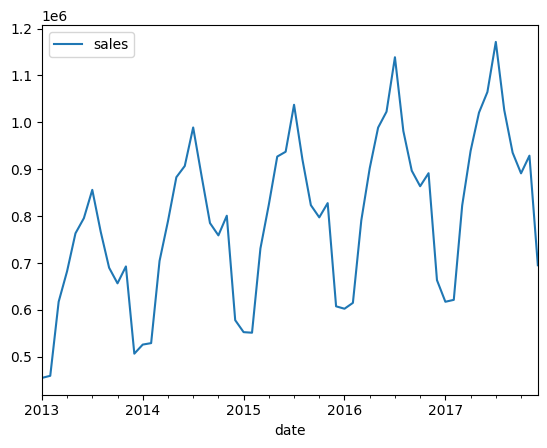

In [79]:
monthly_sales.plot()

In [80]:
#Performing adfuller test to make data stationary
test_result=adfuller(monthly_sales['sales'])
def adfuller_test(sales):
  result=adfuller(sales)
  labels=['ADF Test Statistic','p-value','No. of Lags Used','No. of Observations Used']
  for value,label in zip(result,labels):
    print(label+' : '+str(value) )
  if result[1] <= 0.05:
    print("Data is now stationary.")
  else:
    print("Data is not stationary.")
adfuller_test(monthly_sales['sales'])

ADF Test Statistic : -5.24751885001635
p-value : 7.026495391574818e-06
No. of Lags Used : 11
No. of Observations Used : 48
Data is now stationary.


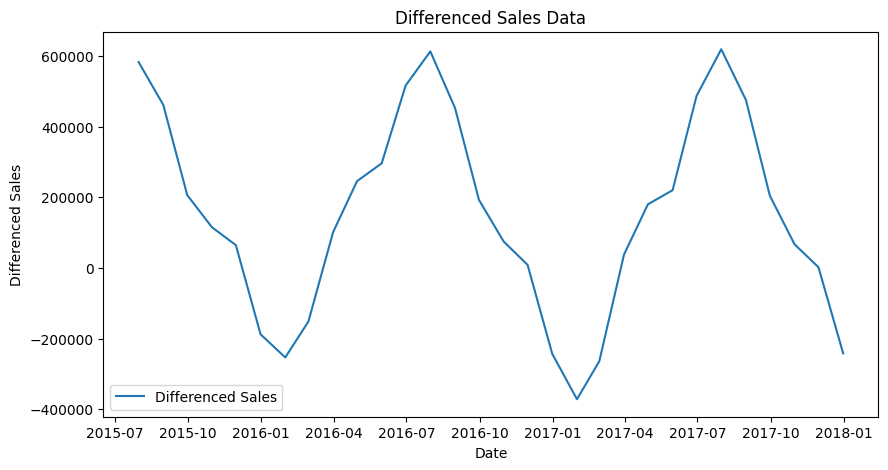

In [81]:
# Perform differencing to make the data stationary
data_diff=monthly_sales['sales']-monthly_sales['sales'].shift(30)
plt.figure(figsize=(10, 5))
plt.plot(data_diff, label='Differenced Sales')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.title('Differenced Sales Data')
plt.legend()
plt.show()
#d value gives the no. of times seasonal differencing was performed. Here, d=1.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


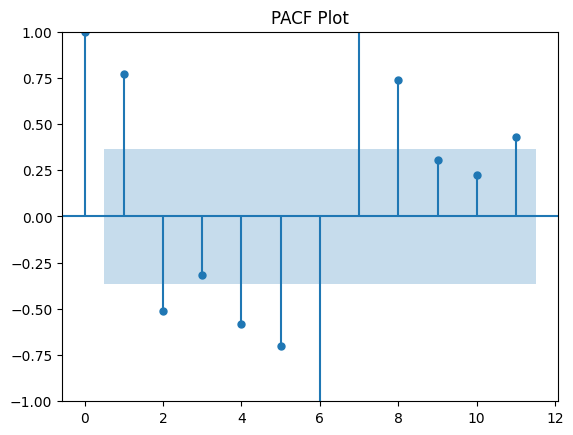

In [82]:
# Check for stationarity using PACF plot
plot_pacf(data_diff.iloc[31:], lags=11)
plt.title('PACF Plot')
plt.show()
#Gives the value of p. Here, it is 1

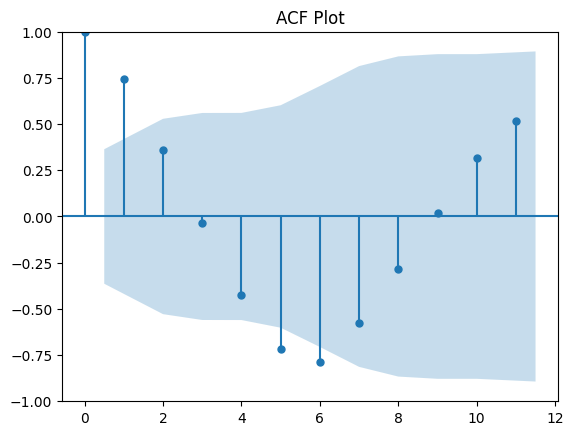

In [83]:
# Check for stationarity using ACF plot
plot_acf(data_diff.iloc[31:], lags=11)
plt.title('ACF Plot')
plt.show()
#Gives the value of q. Here, it is 1.

In [84]:
#Order (p,q,d) is (1,1,1)
#Implementing ARIMA
model=ARIMA(monthly_sales['sales'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -765.206
Date:                Tue, 08 Aug 2023   AIC                           1536.411
Time:                        05:10:16   BIC                           1542.644
Sample:                    01-31-2013   HQIC                          1538.844
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4879      0.503      0.971      0.332      -0.497       1.473
ma.L1         -0.3146      0.558     -0.564      0.573      -1.409       0.779
sigma2      1.106e+10    5.1e-11   2.17e+20      0.000    1.11e+10    1.11e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.27
Prob(Q):                              0.91   Prob(JB):                         0.20
Heteroskedasticity (H):               1.70   Skew:                            -0.58
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.47e+36. Standard errors may be unstable.
"""

<ipython-input-89-b193ad9a767f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_sales['forecast']=model_fit.predict(start=1,end=365)


<Axes: xlabel='date'>

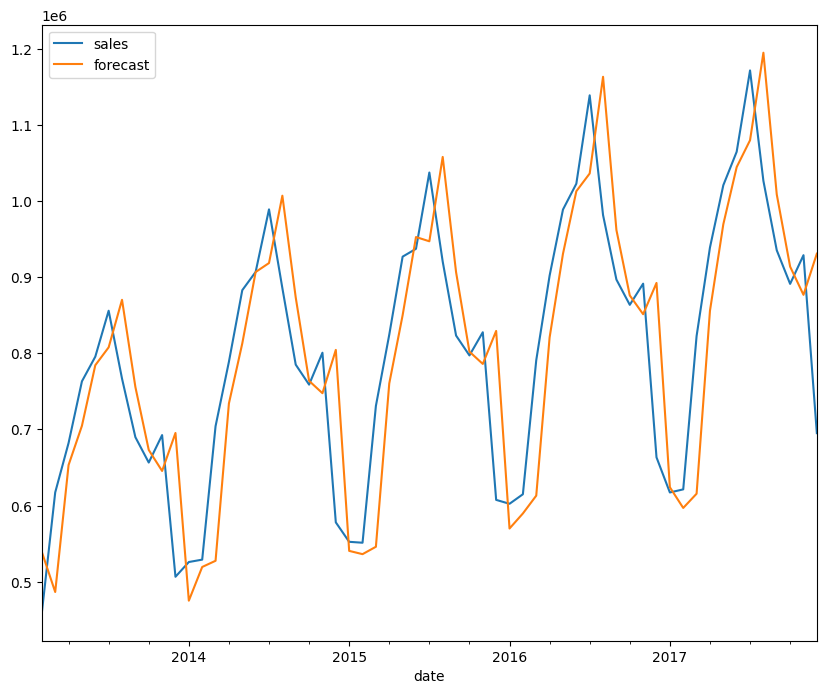

In [89]:
#Regression by ARIMA
monthly_sales['forecast']=model_fit.predict(start=1,end=365)
monthly_sales[['sales','forecast']].plot(figsize=(10,8))

In [86]:
print(monthly_sales['sales'].isna().sum())
print(monthly_sales['forecast'].isna().sum())
monthly_sales=monthly_sales.dropna(subset='forecast')
print(monthly_sales['forecast'].isna().sum())

0
1
0


In [87]:
#Efficiency
mae = mean_absolute_error(monthly_sales['sales'], monthly_sales['forecast'])
mse = mean_squared_error(monthly_sales['sales'], monthly_sales['forecast'])
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 79740.82482860464
Mean Squared Error: 10779929450.972954
Root Mean Squared Error: 103826.43907489534
